# 对抗示例生成

`Ascend` `GPU` `CPU` `进阶` `计算机视觉` `全流程`

[![在线运行](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9yMS41L3R1dG9yaWFscy96aF9jbi9taW5kc3BvcmVfYWR2ZXJzYXJpYWxfZXhhbXBsZV9nZW5lcmF0aW9uLmlweW5i&imageid=59a6e9f5-93c0-44dd-85b0-82f390c5d53b)&emsp;[![下载Notebook](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_adversarial_example_generation.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_adversarial_example_generation.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/intermediate/image_and_video/adversarial_example_generation.ipynb)

近年来随着数据、计算能力、理论的不断发展演进，深度学习在图像、文本、语音、自动驾驶等众多领域都得到了广泛应用。与此同时，人们也越来越关注各类模型在使用过程中的安全问题，因为AI模型很容易受到外界有意无意的攻击而产生错误的结果。在本案例中，我们将以梯度符号攻击FGSM（Fast Gradient Sign Method）为例，演示此类攻击是如何误导模型的。

> 本篇基于CPU/GPU/Ascend环境运行。

## 对抗样本定义

Szegedy在2013年最早提出对抗样本的概念：在原始样本处加入人类无法察觉的微小扰动，使得深度模型性能下降，这种样本即对抗样本。如下图所示，本来预测为“panda”的图像在添加噪声之后，模型就将其预测为“gibbon”，右边的样本就是一个对抗样本：

![fgsm-panda-image](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/intermediate/image_and_video/images/panda.png)

> 图片来自[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)。

## 攻击方法

对模型的攻击方法可以按照以下方法分类：

1. 攻击者掌握的信息多少：

   - 白盒攻击：攻击者具有对模型的全部知识和访问权限，包括模型结构、权重、输入、输出。攻击者在产生对抗性攻击数据的过程中能够与模型系统有所交互。攻击者可以针对被攻击模型的特性设计特定的攻击算法。

   - 黑盒攻击：与白盒攻击相反，攻击者仅具有关于模型的有限知识。攻击者对模型的结构权重一无所知，仅了解部分输入输出。

2. 攻击者的目的：

   - 有目标的攻击：攻击者将模型结果误导为特定分类。

   - 无目标的攻击：攻击者只想产生错误结果，而不在乎新结果是什么。

本案例中用到的FGSM是一种白盒攻击方法，既可以是有目标也可以是无目标攻击。

更多的模型安全功能可参考[MindArmour](https://www.mindspore.cn/mindarmour)，现支持FGSM、LLC、Substitute Attack等多种对抗样本生成方法，并提供对抗样本鲁棒性模块、Fuzz Testing模块、隐私保护与评估模块，帮助用户增强模型安全性。

### 快速梯度符号攻击（FGSM）

正常分类网络的训练会定义一个损失函数，用于衡量模型输出值与样本真实标签的距离，通过反向传播计算模型梯度，梯度下降更新网络参数，减小损失值，提升模型精度。

FGSM（Fast Gradient Sign Method）是一种简单高效的对抗样本生成方法。不同于正常分类网络的训练过程，FGSM通过计算loss对于输入的梯度$\nabla_x J(\theta ,x ,y)$，这个梯度表征了loss对于输入变化的敏感性。然后在原始输入加上上述梯度，使得loss增大，模型对于改造后的输入样本分类效果变差，达到攻击效果。对抗样本的另一要求是生成样本与原始样本的差异要尽可能的小，使用sign函数可以使得修改图片时尽可能的均匀。

产生的对抗扰动用公式可以表示为：

$$ \eta  = \varepsilon  sign(\nabla_x  J(\theta))$$

对抗样本可公式化为：

$$ x' = x + \epsilon \times sign(\nabla_x J(\theta ,x ,y)) $$

其中，

- $x$：正确分类为“Pandas”的原始输入图像。
- $y$：是$x$的输出。
- $\theta$：模型参数。
- $\varepsilon$：攻击系数。
- $J(\theta, x, y)$：训练网络的损失。
- $\nabla_x  J(\theta)$：反向传播梯度。

## 实验前准备

### 导入模型训练需要的库

本案例将使用MNIST训练一个精度达标的LeNet网络，然后运行上文中所提到的FGSM攻击方法，实现错误分类的效果。

首先导入模型训练需要的库

In [1]:
import os
import numpy as np

from mindspore import Tensor, context, Model, load_checkpoint, load_param_into_net
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.common.initializer import Normal
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

### 下载数据集

以下示例代码将数据集下载并解压到指定位置。

In [ ]:
import os
import requests

requests.packages.urllib3.disable_warnings()

def download_dataset(dataset_url, path):
    filename = dataset_url.split("/")[-1]
    save_path = os.path.join(path, filename)
    if os.path.exists(save_path):
        return
    if not os.path.exists(path):
        os.makedirs(path)
    res = requests.get(dataset_url, stream=True, verify=False)
    with open(save_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(dataset_url), path))

train_path = "datasets/MNIST_Data/train"
test_path = "datasets/MNIST_Data/test"

download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte", test_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte", test_path)

下载的数据集文件的目录结构如下：

```text
./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

## 攻击准备

在完成准备工作之后，开始训练精度达标的LeNet网络。

采用`GRAPH_MODE`在CPU/GPU/Ascend中运行本案例，下面将硬件设定为Ascend：

In [3]:
context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

### 训练LeNet网络

实验中使用LeNet作为演示模型完成图像分类，这里先定义网络并使用MNIST数据集进行训练。

定义LeNet网络：

In [4]:
class LeNet5(nn.Cell):

    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

net = LeNet5()

进行数据处理：

In [5]:
def create_dataset(data_path, batch_size=1, repeat_size=1, num_parallel_workers=1):

    # 定义数据集
    mnist_ds = ds.MnistDataset(data_path)
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # 定义所需要操作的map映射
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # 使用map映射函数，将数据操作应用到数据集
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # 进行shuffle、batch、repeat操作
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(count=repeat_size)

    return mnist_ds

定义优化器与损失函数：

In [6]:
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(net.trainable_params(), learning_rate=0.01, momentum=0.9)

定义网络参数：

In [7]:
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)

定义LeNet网络的训练函数和测试函数：

In [8]:
def test_net(model, data_path):
    ds_eval = create_dataset(os.path.join(data_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("{}".format(acc))

def train_net(model, epoch_size, data_path, repeat_size, ckpoint_cb, sink_mode):
    ds_train = create_dataset(os.path.join(data_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125)], dataset_sink_mode=sink_mode)

In [9]:
train_epoch = 1
mnist_path = "./datasets/MNIST_Data/"
repeat_size = 1
model = Model(net, net_loss, net_opt, metrics={"Accuracy": nn.Accuracy()})

训练LeNet网络：

In [10]:
train_net(model, train_epoch, mnist_path, repeat_size, ckpoint, False)

epoch: 1 step: 125, loss is 2.3018382
epoch: 1 step: 250, loss is 2.2910337
epoch: 1 step: 375, loss is 2.2876282
epoch: 1 step: 500, loss is 2.293197
epoch: 1 step: 625, loss is 2.2983356
epoch: 1 step: 750, loss is 0.73134214
epoch: 1 step: 875, loss is 0.39000687
epoch: 1 step: 1000, loss is 0.12004304
epoch: 1 step: 1125, loss is 0.10009943
epoch: 1 step: 1250, loss is 0.31425583
epoch: 1 step: 1375, loss is 0.14330618
epoch: 1 step: 1500, loss is 0.05759584
epoch: 1 step: 1625, loss is 0.18315211
epoch: 1 step: 1750, loss is 0.19758298
epoch: 1 step: 1875, loss is 0.0815863


测试此时的网络，可以观察到LeNet已经达到比较高的精度：

In [11]:
test_net(model, mnist_path)

{'Accuracy': 0.9691}


加载已经训练好的LeNet模型：

In [ ]:
param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
load_param_into_net(net, param_dict)

### 实现FGSM

在得到精准的LeNet网络之后，下面将会采用FSGM攻击方法，在图像中加载噪声后重新进行测试。

先通过损失函数求取反向梯度：

In [13]:
class WithLossCell(nn.Cell):
    """
    包装网络与损失函数
    """
    def __init__(self, network, loss_fn):
        super(WithLossCell, self).__init__()
        self._network = network
        self._loss_fn = loss_fn

    def construct(self, data, label):
        out = self._network(data)
        return self._loss_fn(out, label)


class GradWrapWithLoss(nn.Cell):
    """
    通过loss求反向梯度
    """
    def __init__(self, network):
        super(GradWrapWithLoss, self).__init__()
        self._grad_all = ops.composite.GradOperation(get_all=True, sens_param=False)
        self._network = network

    def construct(self, inputs, labels):
        gout = self._grad_all(self._network)(inputs, labels)
        return gout[0]


然后根据公式实现FGSM攻击：

In [14]:
class FastGradientSignMethod:
    """
    实现FGSM攻击
    """
    def __init__(self, network, eps=0.07, loss_fn=None):
        # 变量初始化
        self._network = network
        self._eps = eps
        with_loss_cell = WithLossCell(self._network, loss_fn)
        self._grad_all = GradWrapWithLoss(with_loss_cell)
        self._grad_all.set_train()


    def _gradient(self, inputs, labels):
        # 求取梯度
        out_grad = self._grad_all(inputs, labels)
        gradient = out_grad.asnumpy()
        gradient = np.sign(gradient)
        return gradient

    def generate(self, inputs, labels):
        # 实现FGSM
        inputs_tensor = Tensor(inputs)
        labels_tensor = Tensor(labels)
        gradient = self._gradient(inputs_tensor, labels_tensor)
        # 产生扰动
        perturbation = self._eps*gradient
        # 生成受到扰动的图片
        adv_x = inputs + perturbation
        return adv_x

    def batch_generate(self, inputs, labels, batch_size=32):
        # 对数据集进行处理
        arr_x = inputs
        arr_y = labels
        len_x = len(inputs)
        batches = int(len_x / batch_size)
        res = []
        for i in range(batches):
            x_batch = arr_x[i*batch_size: (i + 1)*batch_size]
            y_batch = arr_y[i*batch_size: (i + 1)*batch_size]
            adv_x = self.generate(x_batch, y_batch)
            res.append(adv_x)
        adv_x = np.concatenate(res, axis=0)
        return adv_x

再次处理MINIST数据集中测试集的图片：

In [15]:
images = []
labels = []
test_images = []
test_labels = []
predict_labels = []

ds_test = create_dataset(os.path.join(mnist_path, "test"), batch_size=32).create_dict_iterator(output_numpy=True)

for data in ds_test:
    images = data['image'].astype(np.float32)
    labels = data['label']
    test_images.append(images)
    test_labels.append(labels)
    pred_labels = np.argmax(model.predict(Tensor(images)).asnumpy(), axis=1)
    predict_labels.append(pred_labels)

test_images = np.concatenate(test_images)
predict_labels = np.concatenate(predict_labels)
true_labels = np.concatenate(test_labels)

## 运行攻击

由FGSM攻击公式中可以看出，攻击系数$\varepsilon$越大，对梯度的改变就越大。当$\varepsilon$ 为零时则攻击效果不体现。

$\eta = \varepsilon sign(\nabla_x  J(\theta))$

现在先观察当$\varepsilon$为零时的攻击效果：

In [16]:
fgsm = FastGradientSignMethod(net, eps=0.0, loss_fn=net_loss)
advs = fgsm.batch_generate(test_images, true_labels, batch_size=32)

adv_predicts = model.predict(Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels))
print(accuracy)

0.9602363782051282


再将$\varepsilon$设定为0.5，尝试运行攻击：

In [17]:
fgsm = FastGradientSignMethod(net, eps=0.5, loss_fn=net_loss)
advs = fgsm.batch_generate(test_images, true_labels, batch_size=32)

adv_predicts = model.predict(Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels))
print(accuracy)

0.3212139423076923


此时LeNet模型的精度大幅降低。

下面演示受攻击照片现在的实际形态，可以看出图片并没有发生明显的改变，然而在精度测试中却有了不一样的结果：

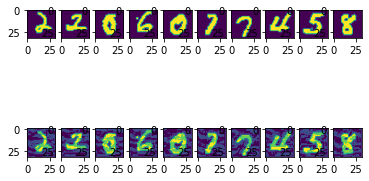

In [18]:
import matplotlib.pyplot as plt

adv_examples = np.transpose(advs[:10], [0, 2, 3, 1])
ori_examples = np.transpose(test_images[:10], [0, 2, 3, 1])

plt.figure()
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.squeeze(ori_examples[i]))
    plt.subplot(2, 10, i+11)
    plt.imshow(np.squeeze(adv_examples[i]))
plt.show()